In [ ]:
import pandas as pd 
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [ ]:
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam = spam.rename(columns={'v1': 'category', 'v2': 'text'})

In [ ]:
spam.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


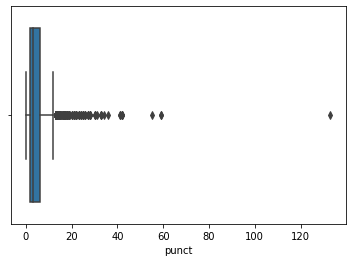

In [ ]:
def punct(x):
  count = 0
  for i in x:
    if i in string.punctuation:
      count+=1
  return count
spam['punct'] = spam.text.apply(lambda x: punct(x))
sns.boxplot(spam.punct)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


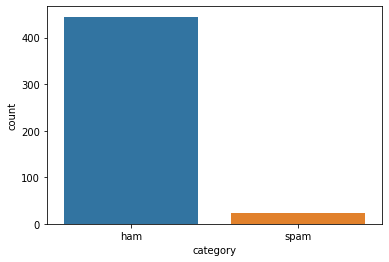

In [ ]:
sns.countplot(spam.query(f'punct == {spam.punct.min()}').category)

In [ ]:
spam['new_text'] = spam.text.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x)))
spam['new_text'] = spam.new_text.apply(lambda x: re.sub(re.compile('<.*?>'),'', str(x)))

In [ ]:
spam['len'] = spam.new_text.apply(lambda x: len(x.split(' ')))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


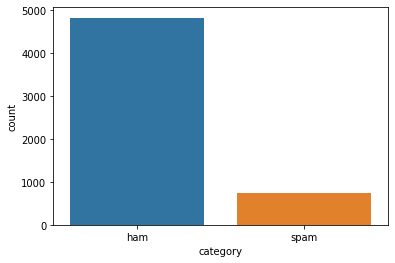

In [ ]:
sns.countplot(spam.category)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


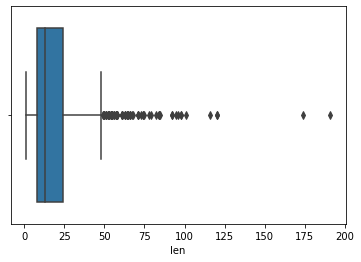

In [ ]:
sns.boxplot(spam.len)

In [ ]:
spam.new_text = spam.new_text.apply(lambda x: nltk.word_tokenize(str(x.lower())))

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
spam.new_text = spam.new_text.apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
spam.new_text.apply(lambda x: len(x)) 


0       16
1        6
2       25
3        9
4        7
        ..
5567    22
5568     5
5569     3
5570    13
5571     3
Name: new_text, Length: 5572, dtype: int64

In [ ]:
spam['stop_words'] = spam.len - spam.new_text.apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


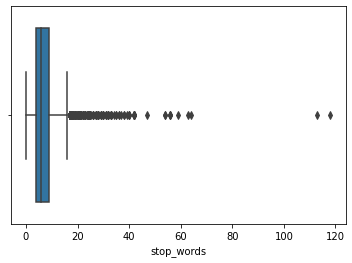

In [ ]:
sns.boxplot(spam.stop_words)

In [ ]:
spam.stop_words.unique()

array([  5,   1,   8,   3,   7,  17,   9,  10,  11,  12,  24,   4,   6,
        15,  18,  20,  25,  16,  13,  23,   2,  19,  40,  14,  33,  47,
         0,  29,  21,  42,  22,  30,  31,  32,  27, 118,  54,  28,  36,
       113,  64,  56,  38,  26,  34,  39,  37,  59,  35,  63])

In [ ]:
spam.query('stop_words == 118')

,category,text,punct,new_text,len,stop_words
1084,ham,For me the love should start with attraction.i...,22,"[love, start, attraction, feel, need, every, t...",191,118


In [ ]:
spam.groupby('category').agg({'stop_words': ['mean', 'median'], 'len': ['mean', 'median'], 'punct': ['mean', 'median']})

stop_words               len            punct       
               mean median       mean median      mean median
category                                                     
ham        7.159793      6  15.309016     12  3.974508      3
spam       7.536814      7  25.756359     27  5.714859      5

In [ ]:
spam.head()

,category,text,punct,new_text,len,stop_words
0,ham,"Go until jurong point, crazy.. Available only ...",9,"[go, jurong, point, crazy, available, bugis, n...",21,5
1,ham,Ok lar... Joking wif u oni...,6,"[ok, lar, joking, wif, u, oni]",7,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,6,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",33,8
3,ham,U dun say so early hor... U c already then say...,6,"[u, dun, say, early, hor, u, c, already, say]",12,3
4,ham,"Nah I don't think he goes to usf, he lives aro...",2,"[nah, think, goes, usf, lives, around, though]",14,7


In [ ]:
lemma = WordNetLemmatizer()
spam.new_text = spam.new_text.apply(lambda x: [lemma.lemmatize(word) for word in x])

In [ ]:
spam.head()


,category,text,punct,new_text,len,stop_words
0,ham,"Go until jurong point, crazy.. Available only ...",9,"[go, jurong, point, crazy, available, bugis, n...",21,5
1,ham,Ok lar... Joking wif u oni...,6,"[ok, lar, joking, wif, u, oni]",7,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,6,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",33,8
3,ham,U dun say so early hor... U c already then say...,6,"[u, dun, say, early, hor, u, c, already, say]",12,3
4,ham,"Nah I don't think he goes to usf, he lives aro...",2,"[nah, think, go, usf, life, around, though]",14,7


In [ ]:
spam.drop('text', axis=1, inplace=True)

In [ ]:
vector = CountVectorizer()
text = vector.fit_transform(spam.new_text.astype('string'))

In [ ]:
text_df = pd.DataFrame(text.todense(), columns=list(vector.get_feature_names())) 

In [ ]:
df = pd.concat([spam, text_df], axis=1)

In [ ]:
df.drop('new_text', axis=1, inplace=True)

In [ ]:
df.shape

(5572, 7963)

In [ ]:
y = spam.category.apply(lambda x: 0 if x=='ham' else 1)
y.unique()

array([0, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('category', axis=1), y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
def metr(y_true, y_pred):
  print(f'roc_auc: {roc_auc_score(y_true, y_pred)}\naccuracy: {accuracy_score(y_true, y_pred)}\nf1 score: {f1_score(y_true, y_pred)}\nrecall: {recall_score(y_true, y_pred)}\nprecision: {precision_score(y_true, y_pred)}')

In [ ]:
rf = RandomForestClassifier(n_estimators=220, max_depth=18, class_weight='balanced')
rf.fit(X_train, y_train)
metr(y_test, rf.predict(X_test))

roc_auc: 0.9261744966442953
accuracy: 0.9802690582959641
f1 score: 0.9202898550724637
recall: 0.8523489932885906
precision: 1.0


In [ ]:
pd.DataFrame({'name': X_train.columns, 'feature': rf.feature_importances_}).sort_values('feature', ascending=False)

,name,feature
1,len,0.086750
1736,call,0.040860
7309,txt,0.023450
3148,free,0.020386
7853,www,0.017691
...,...,...
3858,inpersonation,0.000000
3857,inperialmusic,0.000000
3855,innocent,0.000000
3853,inner,0.000000


In [ ]:
xg = xgb.XGBClassifier(scale_pos_weigh=0)
xg.fit(X_train, y_train)
metr(y_test, xg.predict(X_test))

roc_auc: 0.8977760640293468
accuracy: 0.9704035874439462
f1 score: 0.8782287822878229
recall: 0.7986577181208053
precision: 0.9754098360655737


In [ ]:
param = {'n_estimators': range(220, 251, 20), 'max_depth': range(15, 25, 3)}
rf_gr = GridSearchCV(rf, param, scoring='roc_auc', n_jobs=-1, cv=5)
rf_gr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=18,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=220, n_jobs=None,
                                              oob_score=False,
                                              r

In [ ]:
metr(y_test, rf_gr.predict(X_test))

roc_auc: 0.9261744966442953
accuracy: 0.9802690582959641
f1 score: 0.9202898550724637
recall: 0.8523489932885906
precision: 1.0


In [ ]:
rf_gr.best_estimator_
#roc = 93, n_estimators=220, max_depth=18

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=220, max_depth=18, class_weight='balanced')
cross_val_score(rf1, X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc')

array([0.99331822, 0.9869117 , 0.98535943, 0.9792855 , 0.98517077])

**Best model: Random Forest(n_estimators=220, max_depth=18, class_weight=balanced)**
<p>Scoring: 
<p>roc_auc: 0.9328859060402684
<p>accuracy: 0.9820627802690582
<p>f1 score: 0.9280575539568345
<p>recall: 0.8657718120805369
<p>precision: 1.0
